### Существует некоторая гипотеза, что за последний месяц мы наблюдаем снижение выручки в некоторых регионах и хотим определить возможную причину этого снижения. 

#### Таблица включает следующие поля:

- InvoiceNo   — идентификатор покупки
- StockCode   — идентификатор товара на складе
- Description — текстовое описание товара
- Quantity    — количество товара
- InvoiceDate — дата покупки
- UnitPrice   — цена товара
- CustomerID  — идентификатор покупателя
- Country     — страна

In [1]:
import pandas     as pd
import pandahouse as ph
import seaborn    as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Online_Retail.csv', encoding='windows-1251')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


#### Посмотрим максимаальную и минимальную дату продаж

In [4]:
print("Max date :",data["InvoiceDate"].max())
print("Min date :",data["InvoiceDate"].min())

Max date : 9/9/11 9:52
Min date : 1/10/11 10:04


#### Ознакомимся с типами данных и количеством пропущенных значений

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Переведем колонку с датой с object на datetime

In [6]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#### Посмотрим ТОП-5 стран по количеству проданных единиц

In [7]:
data_set = data \
    .groupby('Country', as_index=False) \
    .agg({'Quantity': 'count'}) \
    .sort_values(by='Quantity', ascending=False) \
    .head(5)
data_set

,Country,Quantity
36,United Kingdom,495478
14,Germany,9495
13,France,8557
10,EIRE,8196
31,Spain,2533


#### Построим столбачатый график для наглядности

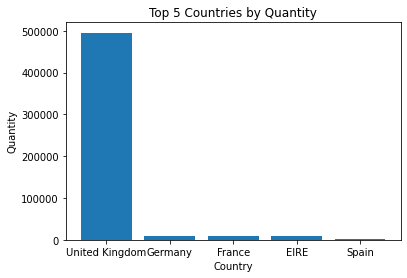

In [8]:
fig, ax = plt.subplots()
ax.bar(data_set['Country'], data_set['Quantity'])
ax.set_xlabel('Country')
ax.set_ylabel('Quantity')
ax.set_title('Top 5 Countries by Quantity')
plt.show()

In [9]:
# подключимся к Кликхаус
connection = {'host': 'https://clickhouse.lab.karpov.courses',
          'database':'default',
              'user':'student', 
          'password':'dpo_python_2020'}

#### Посчитаем количество строк в датасете

In [10]:
# получим данные из Кликхаус в пандас df
query = '''
SELECT 
    count(*) rows_count
FROM 
    default.retail
        '''
df = ph.read_clickhouse(query, connection=connection)
df

,rows_count
0,406829


#### Посчитаем выручку по странам

In [11]:
ph.convert.CH2PD['Decimal(38, 3)'] = 'float'
revenue = '''
SELECT
    SUM(UnitPrice * Quantity) AS Revenue,    
    Country    
FROM 
    retail   
GROUP BY 
    Country 
ORDER BY 
    Revenue DESC
LIMIT 10
    
'''

revenue_df = ph.read_clickhouse(query=revenue, connection=connection)
revenue_df

,Revenue,Country
0,6767873.394,United Kingdom
1,284661.540,Netherlands
2,250285.220,EIRE
3,221698.210,Germany
4,196712.840,France
5,137077.270,Australia
6,55739.400,Switzerland
7,54774.580,Spain
8,40910.960,Belgium
9,36595.910,Sweden


#### Посмотрим среднее количество купленных товаров и среднюю цену товара в покупках, совершенных в ТОП-5 странах

Так же, заметим, что в данных встречаются строки с Description 'Manual', которые включают данные об удаленных из чека позициях, отфильтруем этот момент

In [12]:
average_price = '''
SELECT 
    AVG(UnitPrice) AS average_price,
    Country   
FROM
    retail   
WHERE
    Description!='Manual'  
GROUP BY 
    Country  
ORDER BY 
    average_price DESC
LIMIT 5
'''
average_price_df = ph.read_clickhouse(query=average_price, connection=connection)
average_price_df


,average_price,Country
0,6.030331,Canada
1,5.387556,Lebanon
2,5.288210,Cyprus
3,5.244173,Malta
4,5.059438,Finland


#### Посмотрим на динамику общей суммы выручки по месяцам

Посчитаем выручку по месяцам, обращая внимание, что в таблице указана цена одной единицы товара и количество купленного товара

In [13]:
rev_month = '''
SELECT 
    SUM(UnitPrice * Quantity) AS revenue,  
    toStartOfMonth(InvoiceDate) AS rev_month    
FROM 
    retail  
WHERE 
    Description!='Manual'    
GROUP BY 
    rev_month  
ORDER BY 
    revenue DESC
'''
rev_month_df = ph.read_clickhouse(query=rev_month, connection=connection)
rev_month_df

,revenue,rev_month
0,1130664.250,2011-11-01
1,971686.470,2011-10-01
2,930599.002,2011-09-01
3,656939.370,2011-05-01
4,646884.590,2011-06-01
5,618218.870,2011-08-01
6,586802.531,2011-07-01
7,580281.770,2011-03-01
8,554382.100,2010-12-01
9,477906.800,2011-01-01


#### Посмотрим на динамику выручки от покупателей, которые в среднем покупают самые дорогие товары. В качестве целевой метрики будем использовать среднюю цену купленного товара, данные посмотрим за март 2011 года

In [14]:
unit_price = '''
SELECT 
    AVG(UnitPrice) AS avg_price,    
    CustomerID    
FROM 
    retail
WHERE 
    Description!='Manual' and toStartOfMonth(InvoiceDate) = '2011-03-01'
GROUP BY 
    CustomerID
ORDER BY 
    avg_price DESC
LIMIT 10
'''
unit_price_df = ph.read_clickhouse(query=unit_price, connection=connection)
unit_price_df

,avg_price,CustomerID
0,295.000000,13452
1,145.000000,13983
2,78.725000,16692
3,37.712500,15257
4,34.950000,12980
5,32.971429,12881
6,29.950000,16061
7,18.653846,17817
8,16.450000,14114
9,16.272500,13316


#### Теперь посмотрим, как изменилось среднее, минимальное и максимальное количество купленного товара в стране с наибольшей выручкой в течение последних месяцев

In [15]:
diff = '''
SELECT 
    toStartOfMonth(InvoiceDate) as month,    
    AVG(Quantity) as avg_q,    
    MIN(Quantity) as min_q,   
    MAX(Quantity) as max_q   
FROM 
    retail
WHERE 
    Description!='Manual' and Country = 'United Kingdom' and Quantity>0
GROUP BY 
    month
ORDER BY 
    avg_q DESC
LIMIT 6
'''
diff_df = ph.read_clickhouse(query=diff, connection=connection)
diff_df

,month,avg_q,min_q,max_q
0,2011-12-01,16.449566,1,80995
1,2011-01-01,15.333664,1,74215
2,2011-08-01,13.458128,1,2880
3,2011-07-01,12.872763,1,3186
4,2011-09-01,12.748891,1,1944
5,2011-04-01,12.489902,1,3114


#### Из предоставленных данных и анализа следующие выводы:

- Снижение выручки может быть связано с изменением объема покупок товаров в United Kingdom, стране с наибольшей выручкой. Распределение среднего, минимального и максимального количества купленных товаров в этой стране за последние 6 месяцев показывает, что среднее количество проданных товаров за месяц падает, что может указывать на снижение спроса или другие факторы.

- Общая выручка за месяц также подтверждает снижение выручки относительно предыдущих месяцев.

- Средняя стоимость товара показывает, что в целом, товары с высокой стоимостью не являются основной причиной снижения выручки.

#### Для более точного определения причин снижения выручки, можно  было так же изучить продажи по категориям товаров, это может нам помочь определить, какие категории товаров страдают больше всего, а затем исследовать возможные внутренние или внешние причины снижения выручки в этих категориях. Данная колонка у нас отсутсвует, поэтому не можем копнУть поглубже

#### Оценим сезонность продаж в прошлом году или годах, если продажи обычно снижаются в определенное время года, то этот фактор также может влиять на текущую ситуацию

In [18]:
seasons = '''
SELECT
    SUM(UnitPrice * Quantity) as revenue,
    MONTH(InvoiceDate) as month
FROM
    retail
WHERE
    toStartOfYear(InvoiceDate) = '2011-01-01' AND
    Description!='Manual'
GROUP BY
    month
ORDER BY
    revenue DESC
'''
seasons_df = ph.read_clickhouse(query=seasons, connection=connection)
seasons_df

,revenue,month
0,1130664.250,11
1,971686.470,10
2,930599.002,9
3,656939.370,5
4,646884.590,6
5,618218.870,8
6,586802.531,7
7,580281.770,3
8,477906.800,1
9,437987.200,2


#### Оценим количество активных клиентов и их средние траты, если активность клиентов снижается, то возможно есть внешние факторы или конкуренция, влияющие на рынок, и стоит исследовать обилие конкурирующих предложений или другие причины, связанные с предпочтениями покупателей

In [19]:
active_customers = '''
SELECT
    COUNT(DISTINCT CustomerID) as active_customers,
    AVG(UnitPrice * Quantity) as avg_spend,
    toStartOfMonth(InvoiceDate) as month
FROM
    retail
WHERE
    Description!='Manual'
GROUP BY
    month
ORDER BY
    active_customers DESC
'''
active_customers_df = ph.read_clickhouse(query=active_customers, connection=connection)
active_customers_df

,active_customers,avg_spend,month
0,1708,17.250725,2011-11-01
1,1423,19.193807,2011-10-01
2,1300,22.816628,2011-09-01
3,1078,22.750359,2011-05-01
4,1049,23.258354,2011-06-01
5,1018,20.892985,2011-03-01
6,983,21.376363,2011-07-01
7,977,22.368437,2011-08-01
8,948,20.669703,2010-12-01
9,897,18.292802,2011-04-01


#### На основе данных о продажах можно сделать следующие выводы:

- Оценивая сезонность продаж, видим, что продажи достигают максимума в последнем квартале, особенно в ноябре и октябре в 2011 году. В начале года в январе продажи находятся на самом низком уровне, после чего происходит увеличение продаж до конца года

- Оценивая число активных клиентов и их средние траты, можно заметить, что количество активных клиентов также возрастает в последнем квартале 2011 года и наибольшее число активных клиентов приходилось на ноябрь и октябрь. В то же время наименьшее число клиентов приходилось на начало года на январь и февраль

#### Исходя из этого, можно сделать вывод, что снижение продаж и клиентской активности в определенное время года действительно может считаться нормой для данного ретейл магазина.